In [33]:
import numpy as np
import pandas as pd
from pandas_datareader import data
from warnings import filterwarnings
from cycler import cycler

filterwarnings('ignore')

import matplotlib.pyplot as plt

plt.style.use(['dark_background', 'fivethirtyeight'])
plt.rcParams['axes.facecolor'] = '#121212'
plt.rcParams['figure.facecolor'] = '#121212'
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['figure.autolayout'] = True ## This makes sure that the subplots are sufficiently far apart
plt.rcParams['axes.prop_cycle'] = cycler('color',['#bb86fc', '#c7fc86', '#ff7697', '#ffffff'])
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['boxplot.boxprops.linewidth'] = 2 
plt.rcParams['boxplot.flierprops.markeredge.color'] = 'white'

KeyError: 'boxplot.flierprops.markeredge.color is not a valid rc parameter (see rcParams.keys() for a list of valid parameters)'

In [2]:
start_date = '2014-01-01'
end_date = '2018-01-01'
SRC_DATA_FILENAME = 'goog_data.pkl'

try:
    goog_data2 = pd.read_pickle(SRC_DATA_FILENAME)
except FileNotFoundError:
    goog_data2 = data.DataReader('GOOG', 'yahoo', start_date, end_date)
    goog_data2.to_pickle(SRC_DATA_FILENAME)

In [3]:
goog_data2.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2014-01-02,556.788025,552.060730,555.647278,554.481689,3656400.0,554.481689
2014-01-03,556.379578,550.401978,555.418152,550.436829,3345800.0,550.436829
2014-01-06,557.340942,551.154114,554.426880,556.573853,3551800.0,556.573853
2014-01-07,567.717041,558.486633,560.399475,567.303589,5124300.0,567.303589
2014-01-08,571.517822,564.528992,570.860291,568.484192,4501700.0,568.484192


In [4]:
goog_data = goog_data2.tail(620)
lows = goog_data.Low
highs = goog_data.High

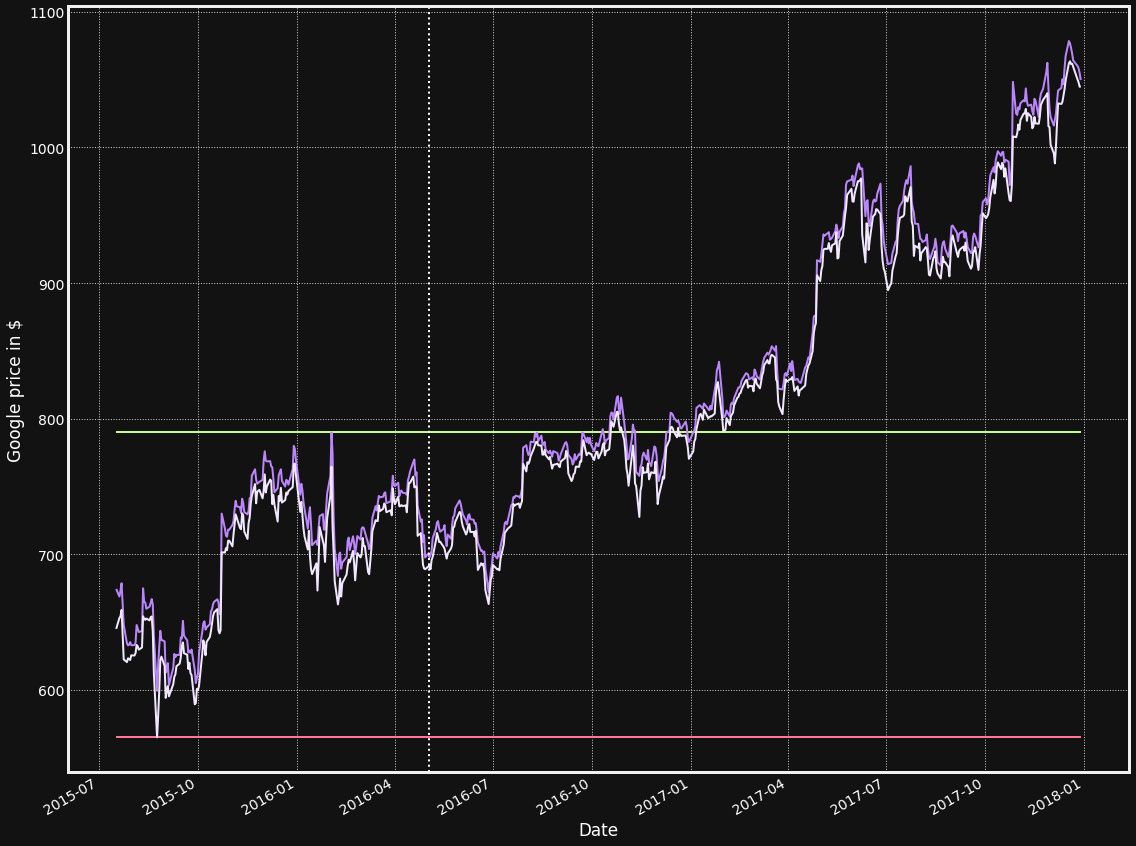

In [5]:
fig = plt.figure(figsize = (16,12))
ax1 = fig.add_subplot(111, ylabel = 'Google price in $')
highs.plot(ax =ax1, color = '#bb86fc')
lows.plot(ax=ax1, color = '#f1e7fe')
plt.hlines(highs.head(200).max(), lows.index.values[0], lows.index.values[-1], 
           linewidth = 2, color = '#c7fc86')
plt.hlines(lows.head(200).min(), lows.index.values[0], lows.index.values[-1], 
           linewidth = 2, color = '#ff7697')
plt.axvline(linewidth = 2, x = lows.index.values[200], linestyle = ':')

In [6]:
def trading_support_resistance(data, bin_width=20):
    data['sup_tolerance'] = pd.Series(np.zeros(len(data)))
    data['res_tolerance'] = pd.Series(np.zeros(len(data)))
    data['sup_count'] = pd.Series(np.zeros(len(data)))
    data['res_count'] = pd.Series(np.zeros(len(data)))
    data['sup'] = pd.Series(np.zeros(len(data)))
    data['res'] = pd.Series(np.zeros(len(data)))
    data['positions'] = pd.Series(np.zeros(len(data)))
    data['signal'] = pd.Series(np.zeros(len(data)))
    
    in_support, in_resistance = 0, 0
    
    for x in range((bin_width ), len(data)):
        data_section = data[x - bin_width:x + 1]
        support_level = min(data_section.price)
        resistance_level = max(data_section.price)
        
        range_level = resistance_level - support_level
        
        data['res'][x] = resistance_level
        data['sup'][x] = support_level
        
        data['sup_tolerance'][x] = support_level + 0.2 * range_level
        data['res_tolerance'][x] = resistance_level - 0.2 * range_level
        
        if data['price'][x] >= data['res_tolerance'][x] and data['price'][x] <= data['res'][x]:
            in_resistance += 1
            data['res_count'][x] = in_resistance
            
        elif data['price'][x] <= data['sup_tolerance'][x] and data['price'][x] >= data['sup'][x]:
            in_support += 1
            data['sup_count'][x] = in_support
        else:
            in_support, in_resistance = 0, 0
            
        if in_resistance > 2:
            data['signal'][x] = 1
            
        elif in_support > 2:
            data['signal'][x] = 0
        
        else:
            data['signal'][x] = data['signal'][x-1]
            
    data['positions'] = data["signal"].diff()

In [7]:
goog_data_signal = pd.DataFrame(index = goog_data2.index)
goog_data_signal['price'] = goog_data2['Adj Close']
trading_support_resistance(goog_data_signal)

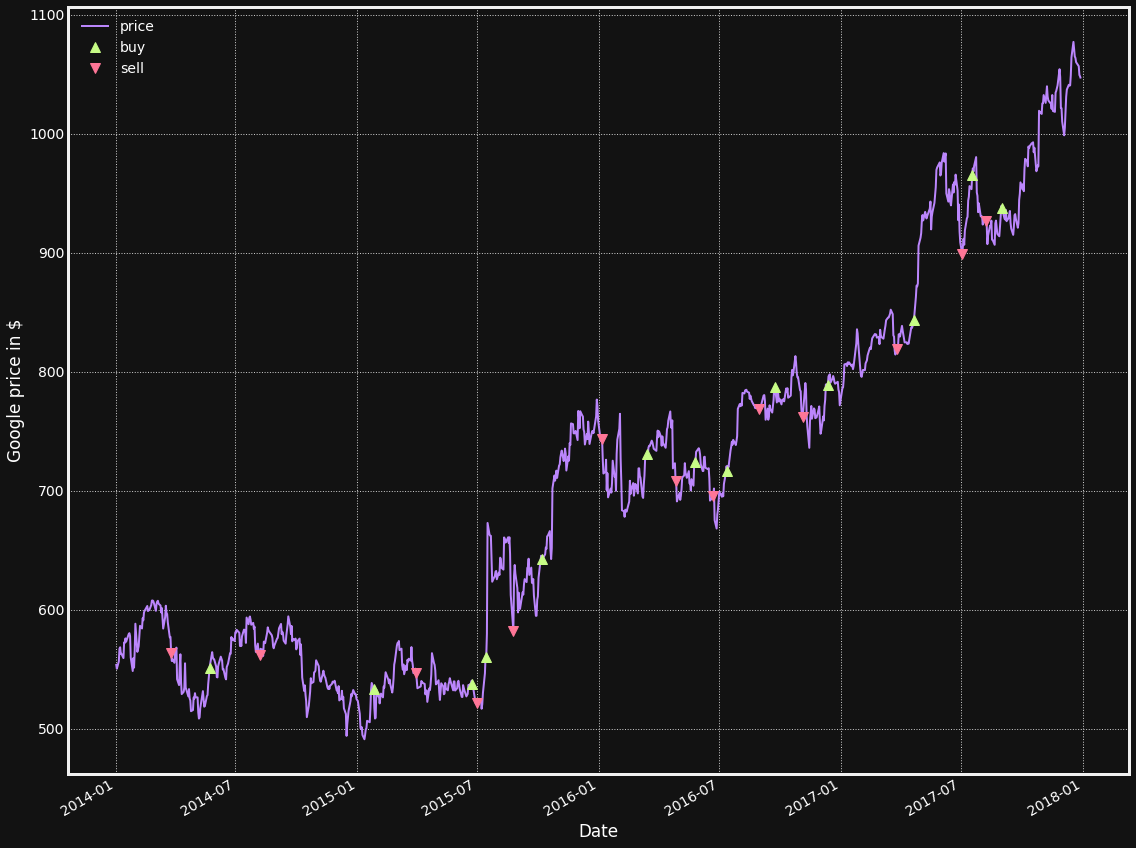

In [8]:
fig = plt.figure(figsize=(16,12))
ax1 = fig.add_subplot(111, ylabel ='Google price in $')
goog_data_signal.price.plot(ax=ax1, color='#bb86fc',lw=2)
# plot up arrows
ax1.plot(goog_data_signal.loc[goog_data_signal.positions == 1].index,
        goog_data_signal.price[goog_data_signal.positions == 1],
        '^',
        markersize=10,
        color='#c7fc86',
        label = 'buy' 
        )
#plot down arrows
ax1.plot(goog_data_signal.loc[goog_data_signal.positions == -1].index, 
        goog_data_signal.price[goog_data_signal.positions == -1],
        'v',
        markersize=10,
        color='#ff7697',
        label = 'sell'
        )
ax1.set_facecolor('#121212')
fig.patch.set_facecolor('#121212')
plt.grid(linestyle = ':')

plt.legend(framealpha = 0)

In [9]:
import statistics as stats

In [10]:
time_period = 20
history = []
sma_values = []

for price in goog_data2.Close:
    history.append(price)
    if len(history) > time_period:
        del(history[0])    
    sma_values.append(stats.mean(history))
    
close_price = goog_data2.Close
sma = pd.Series(sma_values, index=goog_data2.index)

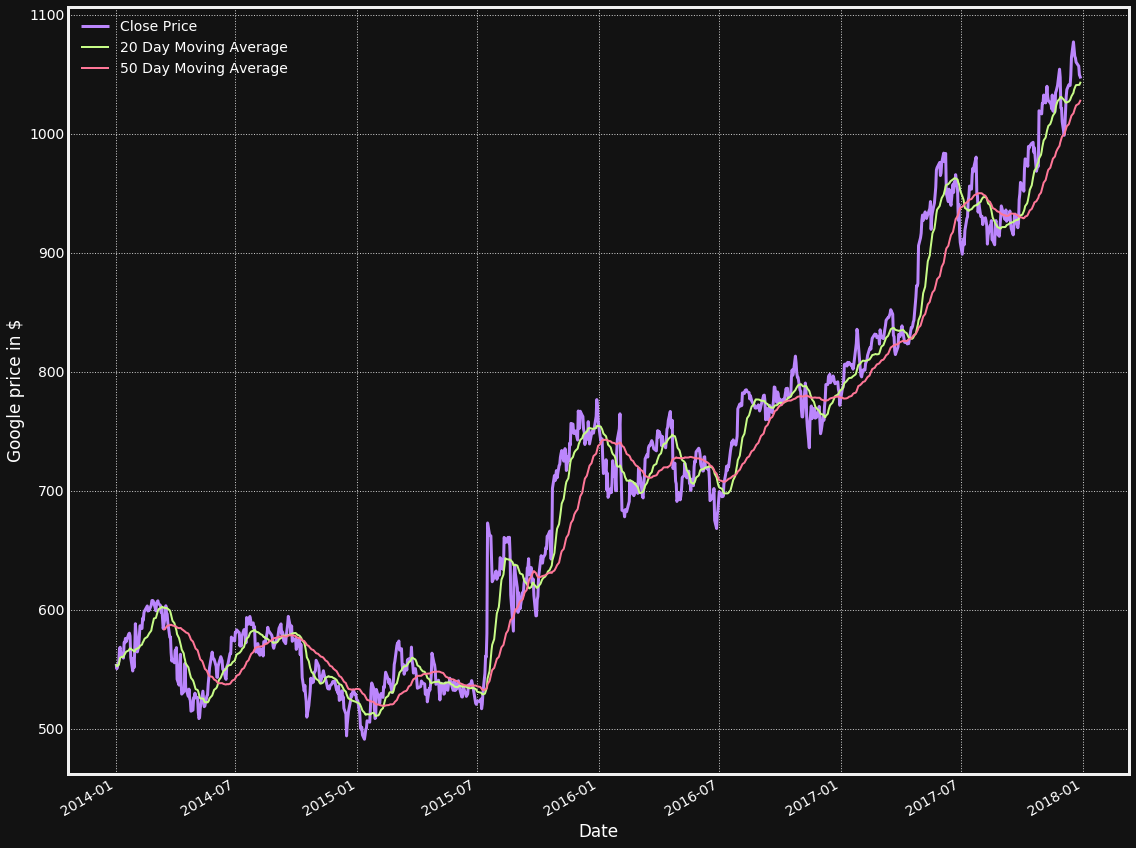

In [11]:
fig = plt.figure(figsize=(16,12))
ax1 = fig.add_subplot(111, ylabel ='Google price in $')

close_price.plot(ax=ax1, color='#bb86fc',lw=3, label='Close Price')
sma.plot(ax=ax1, color='#c7fc86', lw=2, label='20 Day Moving Average')

close_price.rolling(window=50).mean().plot(ax=ax1, color='#ff7697', lw=2, label='50 Day Moving Average')

ax1.set_facecolor('#121212')
fig.patch.set_facecolor('#121212')
plt.grid(linestyle = ':')

plt.legend(framealpha = 0)

### Exponential moving average

In [12]:
def exp_moving_average(series, n):
    
    K = 2/(n+1)
    
    ema_p = 0
    ema_values = []
    
    for elt in series:
        if ema_p == 0:
            ema_p = elt
        else:
            ema_p = (elt - ema_p) * K + ema_p
        ema_values.append(ema_p)
        
    return pd.Series(ema_values, index=series.index)
    

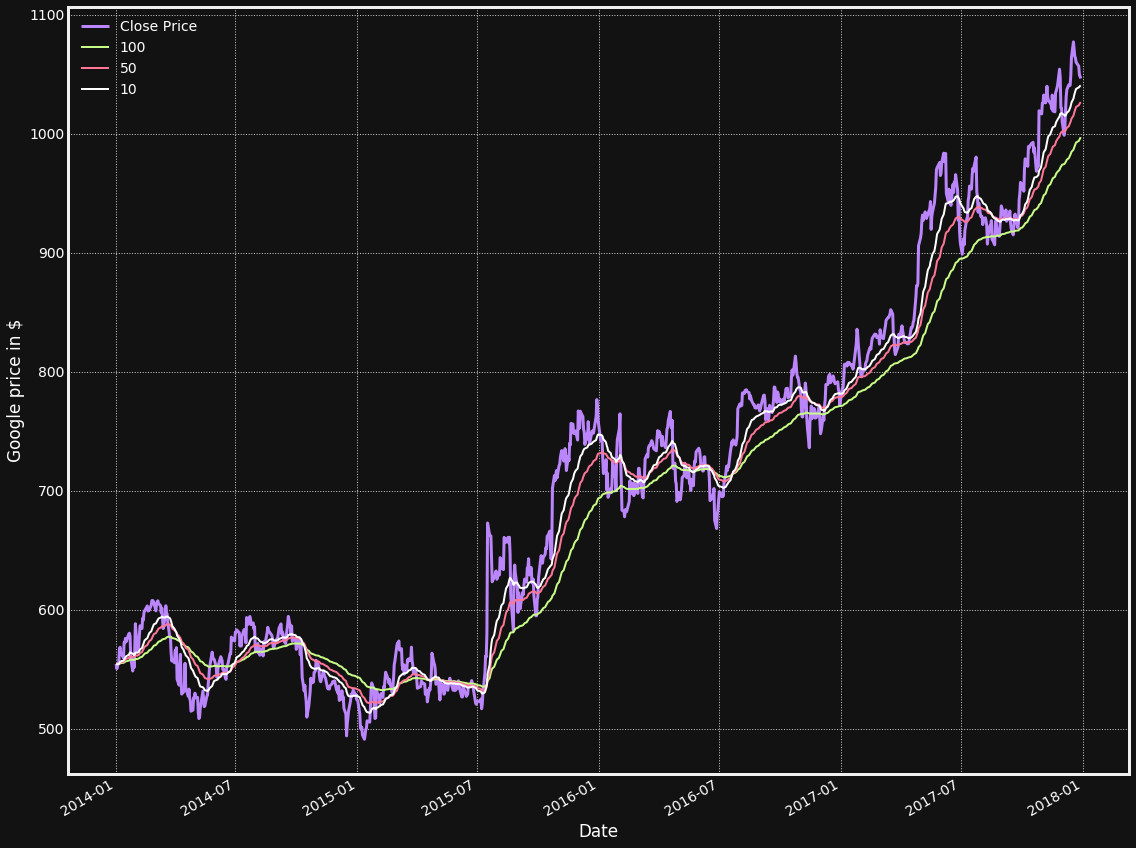

In [13]:
fig = plt.figure(figsize=(16,12))
ax1 = fig.add_subplot(111, ylabel ='Google price in $')

close_price.plot(ax=ax1 ,lw=3, label='Close Price')
#sma.plot(ax=ax1, color='#c7fc86', lw=2, label='20 Day Moving Average')
#close_price.rolling(window=50).mean().plot(ax=ax1, color='#ff7697', lw=2, label='50 Day Moving Average')
exp_moving_average(close_price, 100).plot(ax=ax1, lw=2, label='100')
exp_moving_average(close_price, 50).plot(ax=ax1, lw=2, label='50')
exp_moving_average(close_price, 30).plot(ax=ax1, lw=2, label='10')



ax1.set_facecolor('#121212')
fig.patch.set_facecolor('#121212')
plt.grid(linestyle = ':')

plt.legend(framealpha = 0)


### Absolute price oscillator.

This measures the difference between slow EMA and fast EMA. Whenever the difference between the two is big this indicates that a trend in the price is emerging or that the instrument is far from it's equilibrium price. 

In [14]:
ema10 = exp_moving_average(close_price, 10)
ema40 = exp_moving_average(close_price, 40)

apo = ema10 - ema40

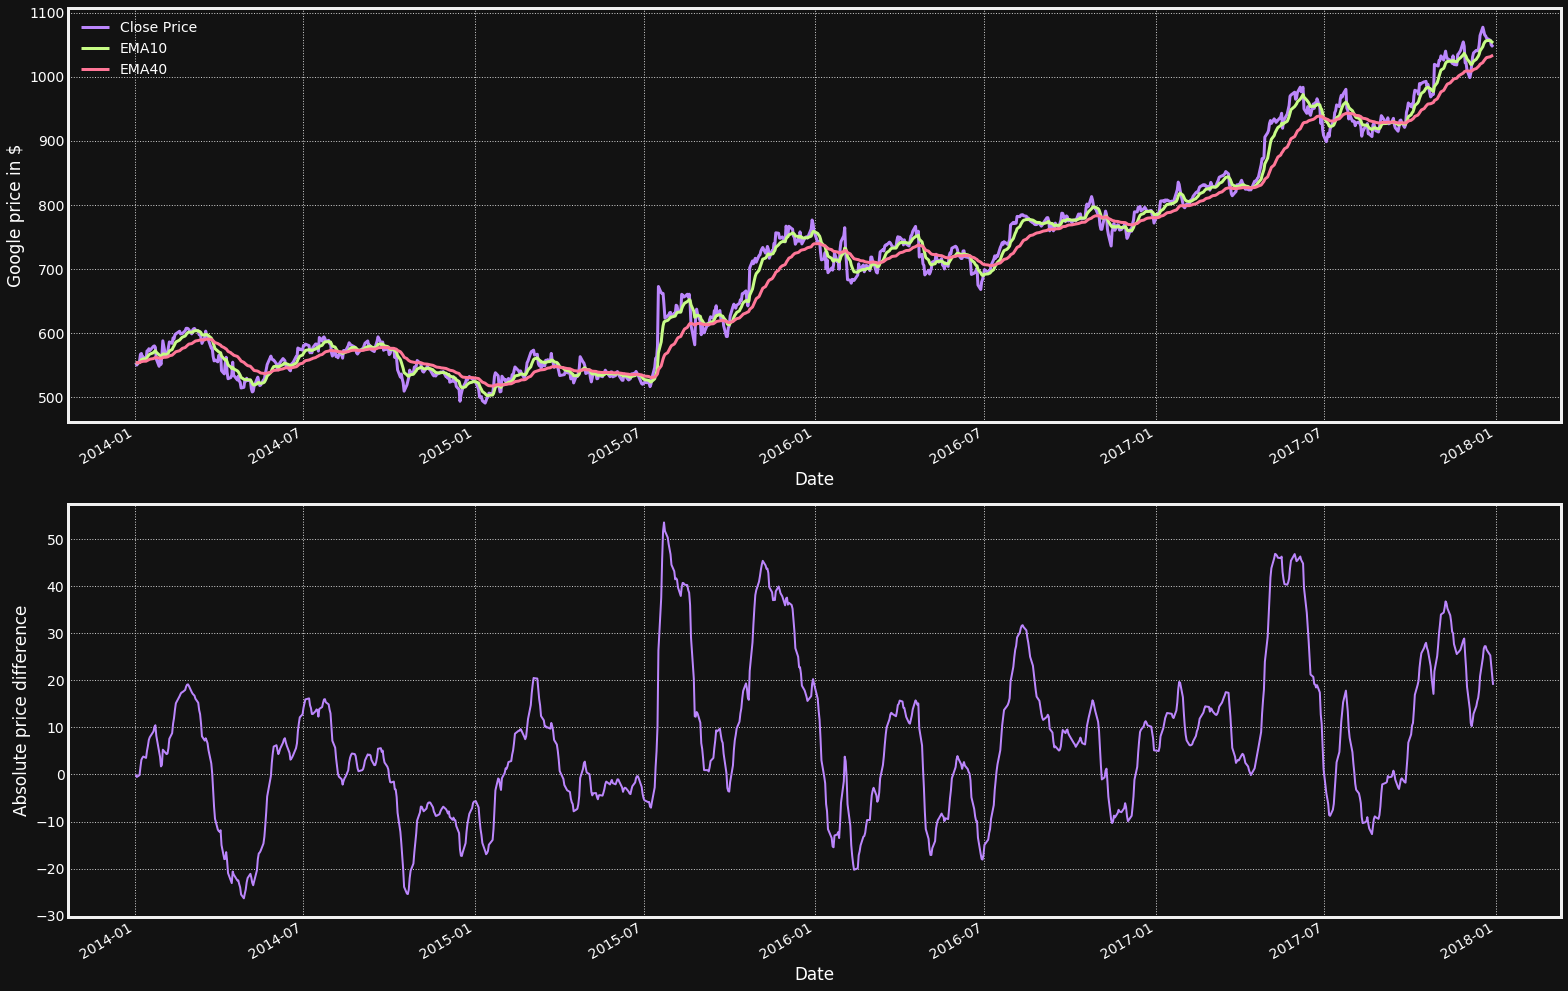

In [15]:
fig = plt.figure(figsize=(22,14))
ax1 = fig.add_subplot(211, ylabel ='Google price in $')

close_price.plot(ax=ax1, color='#bb86fc',lw=3, label='Close Price')
ema10.plot(ax=ax1, color='#c7fc86',lw=3, label='EMA10')
ema40.plot(ax=ax1, color='#ff7697',lw=3, label='EMA40')

ax2 = fig.add_subplot(212, ylabel='Absolute price difference')

apo.plot(ax=ax2)


ax1.set_facecolor('#121212')
ax2.set_facecolor('#121212')
fig.patch.set_facecolor('#121212')

ax1.legend(framealpha = 0)

### Moving average convergence divergence

Here we compute the difference between fast and slow EMA. Then we apply exponential moving average to this signal yet again.
We take:

EMA_fast: n = 10
EMA_slow: n = 40

Smoothing factor for MACD: n = 20

In [16]:
# we have ema10 and ema 40 from before. To get MACD we apply the exp_moving_average function to the apo series with factor n = 20

macd_signal = exp_moving_average(apo, 20)
macd_hist = apo-macd_signal

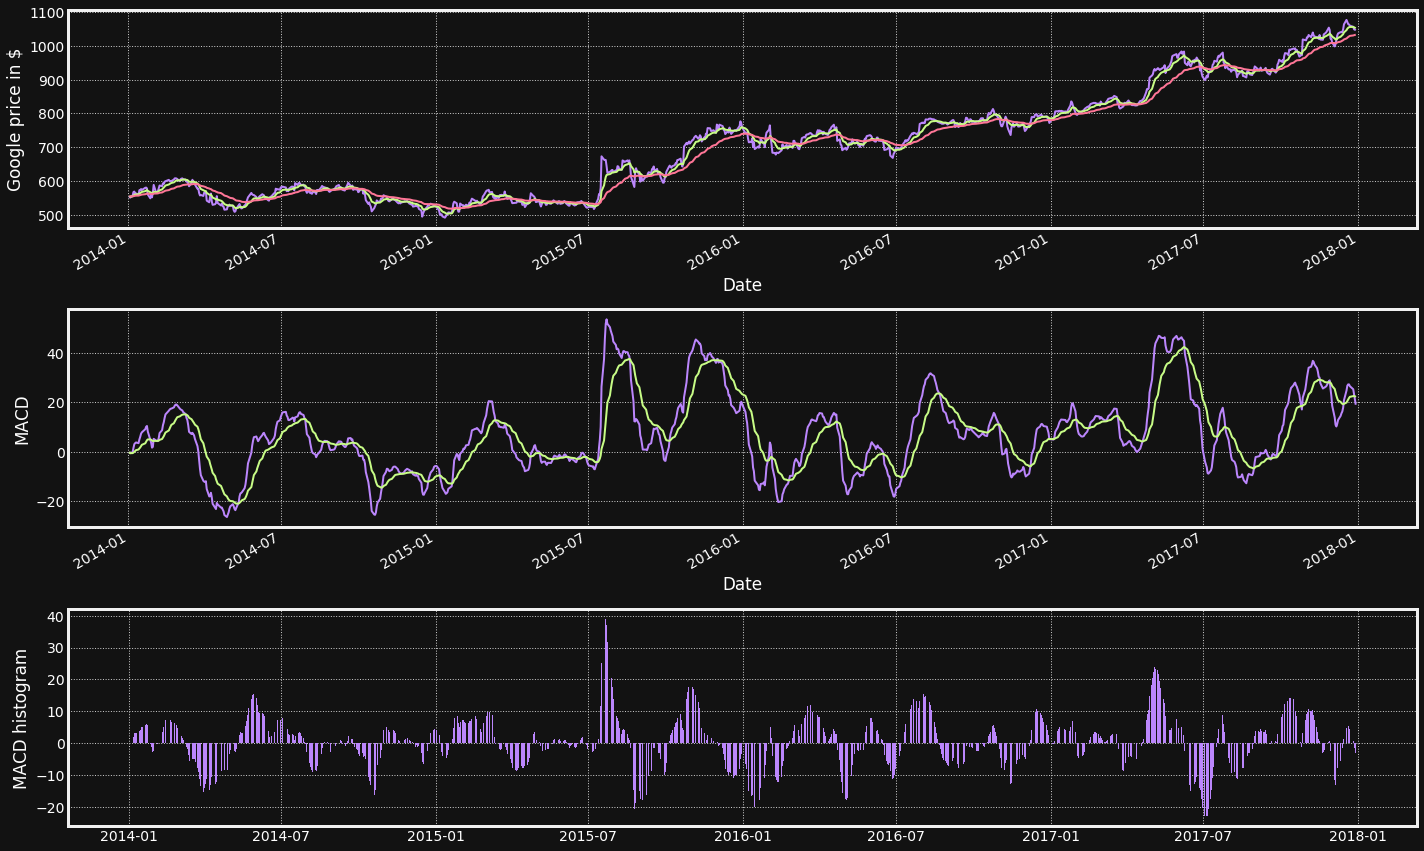

In [17]:
fig = plt.figure(figsize=(20,12))
ax1 = fig.add_subplot(311,ylabel='Google price in $') 
ax2 = fig.add_subplot(312,ylabel='MACD')
ax3 = fig.add_subplot(313,ylabel='MACD histogram')

#plot 1
close_price.plot(ax=ax1)
ema10.plot(ax=ax1)
ema40.plot(ax=ax1)


#plot 2
apo.plot(ax=ax2)
macd_signal.plot(ax=ax2)

#plot 3
ax3.bar(x=macd_hist.index, height=macd_hist)


plt.show()


### Bollinger bands

Bollinger bands indicate volatility of the price by indicating the standard deviation of the last n time periods. We will use the standard moving average as the mean but the exponential moving average may be used as well.

In [18]:
def bollinger_bands(series, n, std_dev_factor=2):
    sma = []
    upper_band = []
    lower_band = []
    queue = []
    for elt in series:
        queue.append(elt)
        if len(queue) > n:
            del(queue[0])
        mov_avg = stats.mean(queue)
        sma.append(mov_avg)
        sigma = np.std(queue)
        upper_band.append(mov_avg + std_dev_factor * sigma)
        lower_band.append(mov_avg - std_dev_factor * sigma)
        
    results = {'sma': sma, 'upper':upper_band, 'lower':lower_band}
    
    return pd.DataFrame(results, index=series.index)

In [19]:
bbands = bollinger_bands(close_price, 20)

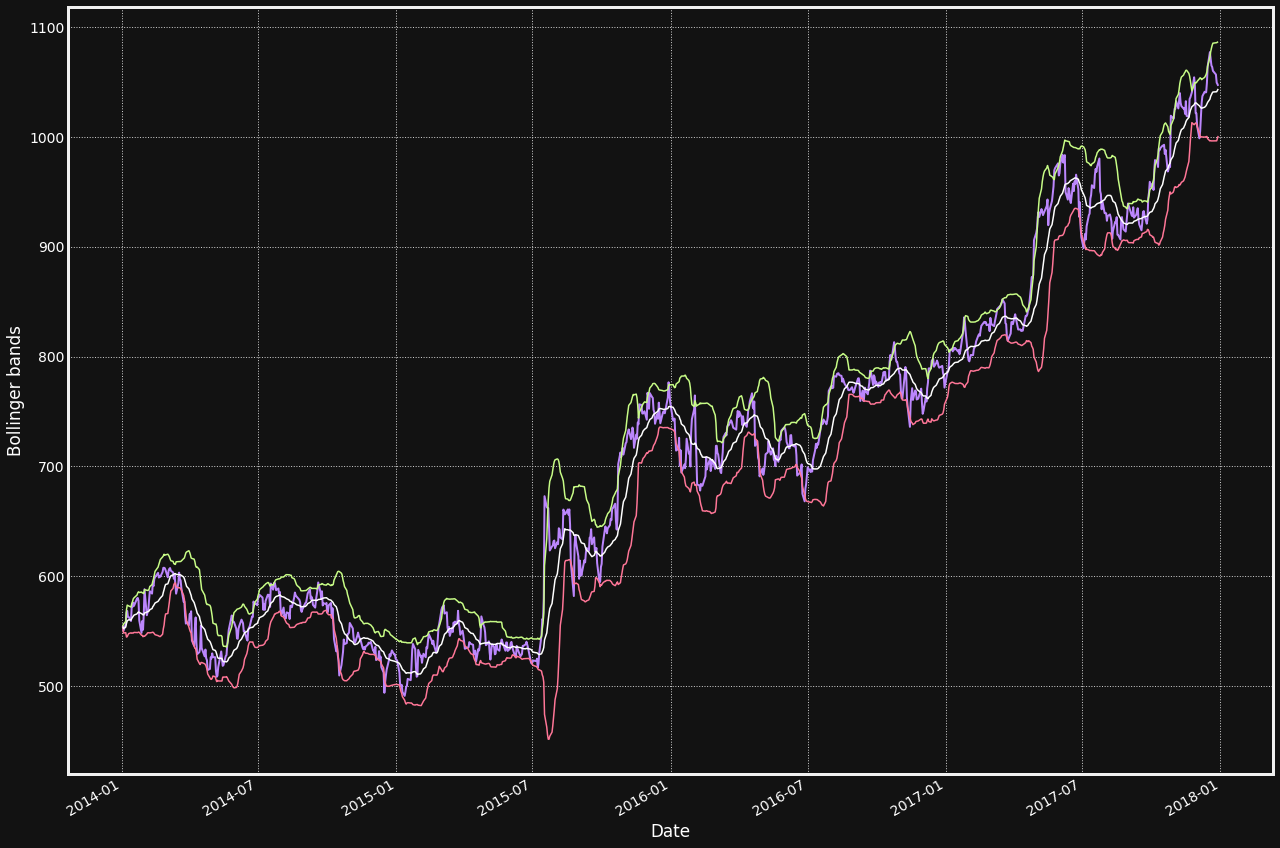

In [20]:
fig = plt.figure(figsize=(18,12))
ax1 = fig.add_subplot(111, ylabel='Bollinger bands')

close_price.plot(ax=ax1)
bbands.upper.plot(ax=ax1,lw=1.5)
bbands.lower.plot(ax=ax1,lw=1.5)
bbands.sma.plot(ax=ax1, color='w', lw = 1.5)


### Relative strength indicator

In [21]:
def RSI(series, n):
    
    gain_history = []
    loss_history = []
    
    avg_gain_values = []
    avg_loss_values = []
    
    rsi_values = []
    
    last_price = 0
    
    for close in series:
        if last_price == 0:
            last_price = close
        
        gain_history.append(max(0, close - last_price))
        loss_history.append(max(0, last_price - close))
        
        last_price = close
        
        if len(gain_history) > n:
            del (gain_history[0])
            del (loss_history[0])
            
        
        avg_gain = np.mean(gain_history)
        avg_loss= np.mean(loss_history)
        avg_gain_values.append(avg_gain)
        avg_loss_values.append(avg_loss)
        
        rs = 0
        
        if avg_loss > 0:
            rs = avg_gain/avg_loss
        
        rsi_values.append(100 - 100/(1+rs))
        
    result = {'avg_gain': avg_gain_values, 'avg_loss': avg_loss_values, 'rsi': rsi_values}
        
    return pd.DataFrame(result, index=series.index)
        

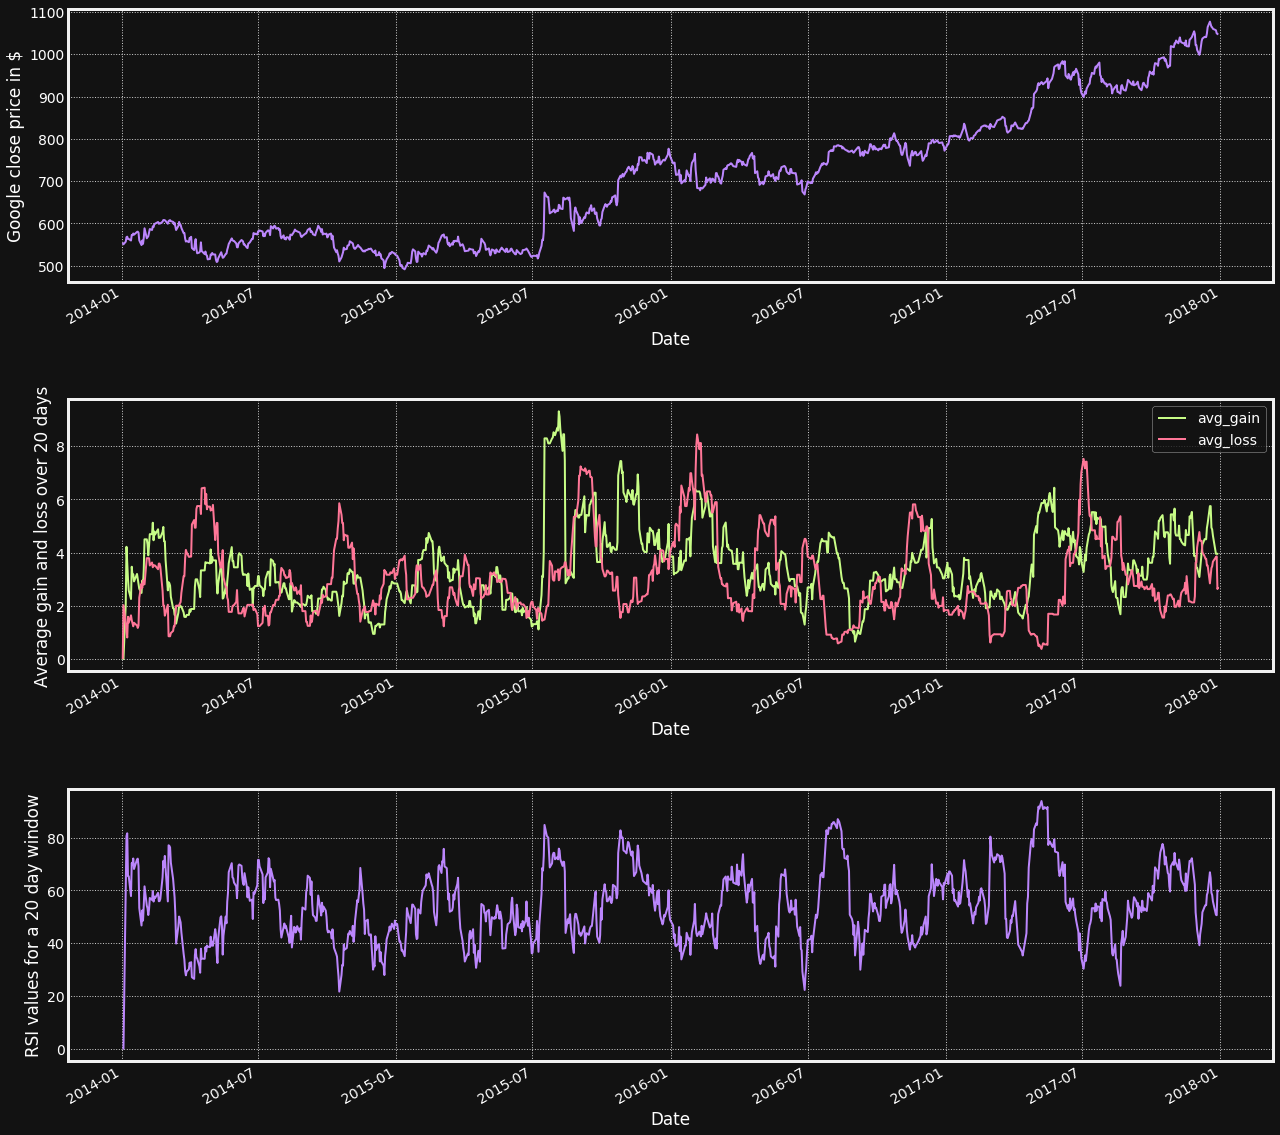

In [22]:
rsi_data = RSI(close_price, 20)

fig = plt.figure(figsize=(18,16))
ax1 = fig.add_subplot(311, ylabel='Google close price in $')
ax2 = fig.add_subplot(312, ylabel='Average gain and loss over 20 days')
ax3 = fig.add_subplot(313, ylabel='RSI values for a 20 day window')

close_price.plot(ax=ax1)
rsi_data.avg_gain.plot(ax=ax2, color = '#c7fc86')
rsi_data.avg_loss.plot(ax=ax2, color = '#ff7697')
rsi_data.rsi.plot(ax=ax3)

ax2.legend()

### Standard deviation / Volatility

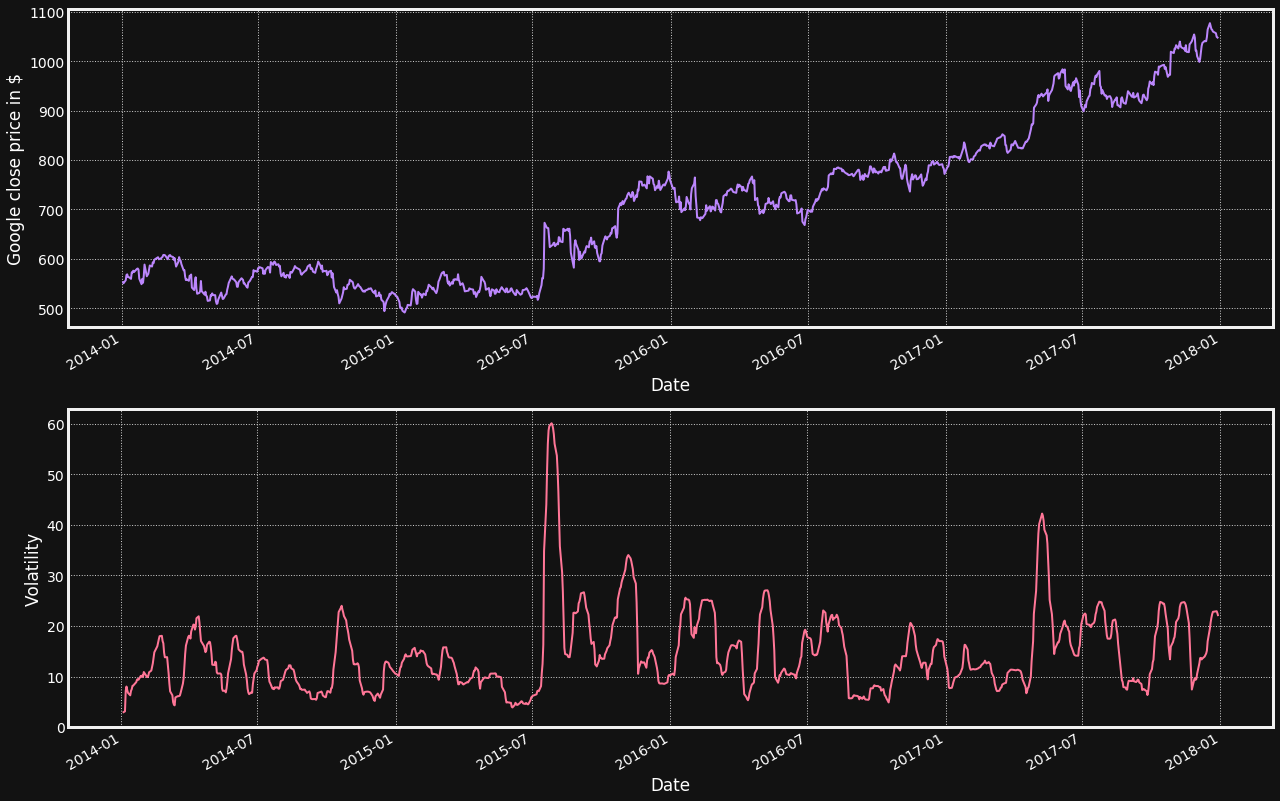

In [23]:
fig = plt.figure(figsize=(18,16))
ax1 = fig.add_subplot(311, ylabel='Google close price in $')
ax2 = fig.add_subplot(312, ylabel='Volatility')

close_price.plot(ax=ax1)
close_price.rolling(20, min_periods=1).std().plot(ax=ax2, color='#ff7697')


In [24]:
def momentum(series, n):
    momentum = []
    history = []
    
    for close_price in series:
        history.append(close_price)
        
        if len(history) > n:
            del(history[0])
            
        mom = close_price - history[0]
        momentum.append(mom)
        
    
    return pd.Series(momentum, index = series.index)

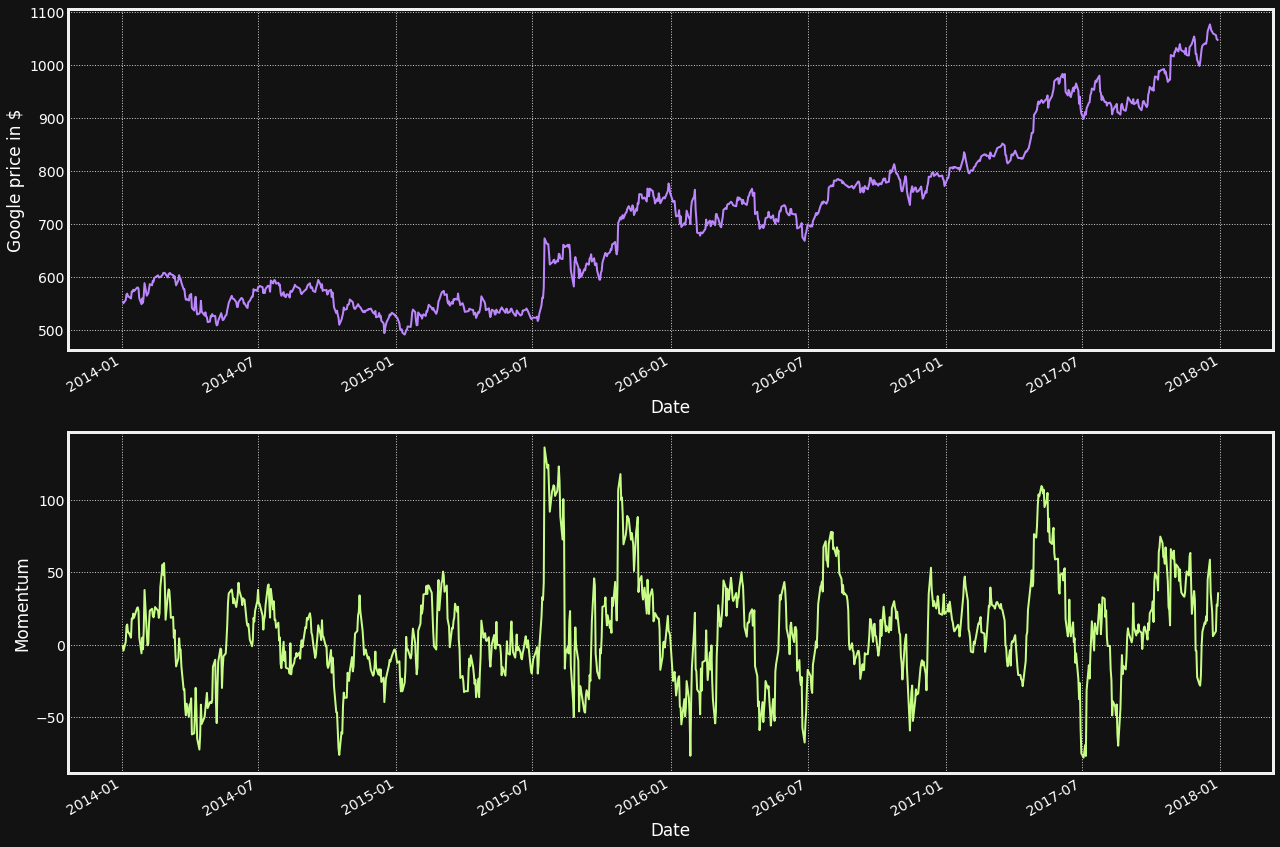

In [25]:
mom = momentum(close_price, 20)

fig = plt.figure(figsize=(18, 12))
ax1 = fig.add_subplot(211, ylabel='Google price in $')
ax2 = fig.add_subplot(212, ylabel='Momentum')

close_price.plot(ax=ax1)
mom.plot(ax=ax2, color='#c7fc86')

### Understanding seasonality

In [29]:
goog_monthly_return = goog_data2['Adj Close'].pct_change().groupby([goog_data2['Adj Close'].index.year,
                                                                  goog_data2['Adj Close'].index.month]).mean()

goog_monthly_return_list = []

for i in range(len(goog_monthly_return)):
    goog_monthly_return_list.append({'month':goog_monthly_return.index[i][1],
                                    'monthly_return':goog_monthly_return[i]}
    )
    
goog_monthly_return_list = pd.DataFrame(goog_monthly_return_list, columns = ('month', 'monthly_return'))

Text(0.5, 0.98, '')

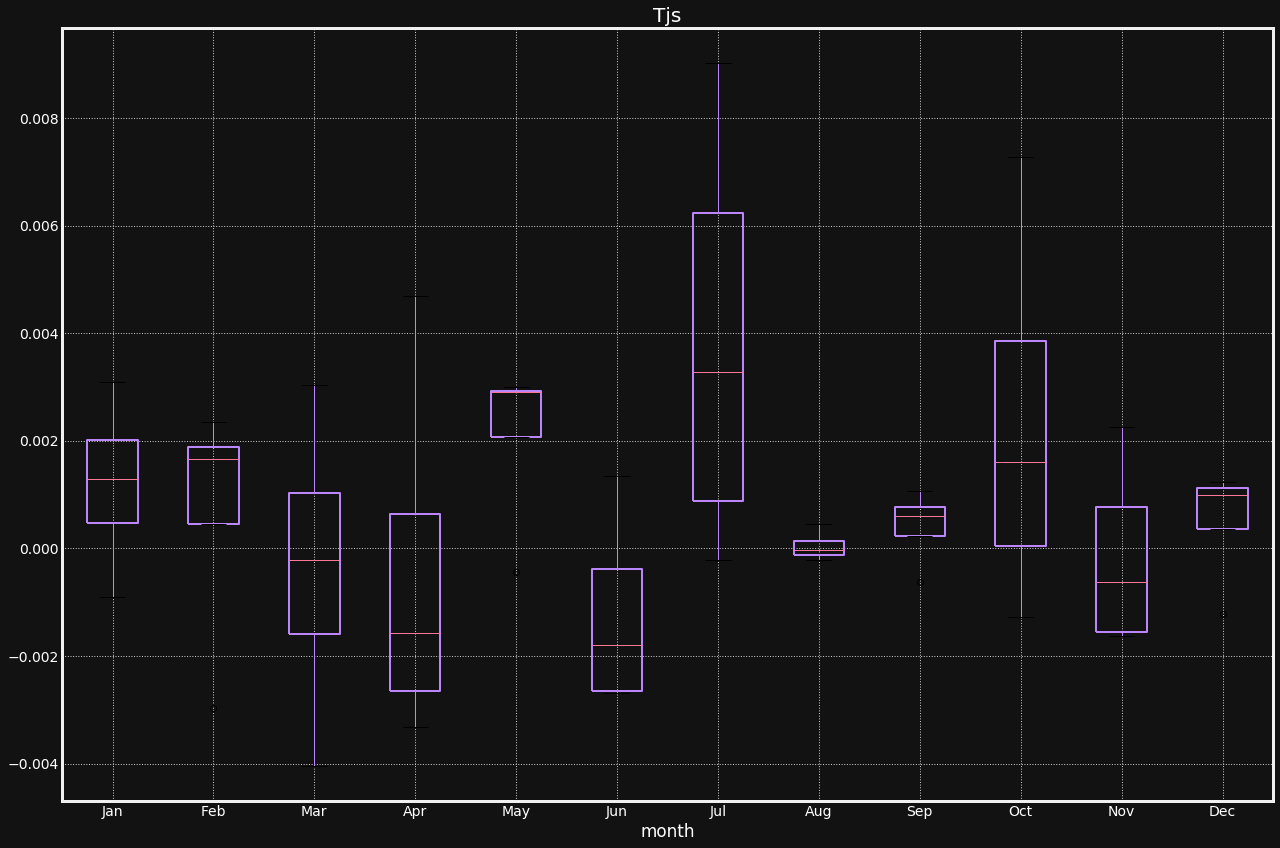

In [32]:
fig = plt.figure(figsize=(18,12))
ax = fig.add_subplot(111)
goog_monthly_return_list.boxplot(ax=ax, column='monthly_return', by='month')
labels= [item.get_text() for item in ax.get_xticklabels()]
labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
ax.set_xticklabels(labels)
ax.set_title('Tjs')
fig.suptitle('')